# Case-by-case analysis
This notebook demonstrates how to visualize which model managed to solve which test-case how often.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
directory = "../data/"

collection = []
for filename in os.listdir(directory):
    if filename.endswith("_results.jsonl"):
        print(filename)
        df = pd.read_json(directory + filename, lines=True)
        df['model'] = filename.replace(".jsonl_results.jsonl", "").replace("samples_", "")
        collection.append(df)

df = pd.concat(collection)

samples_canonical.jsonl_results.jsonl


In [3]:
df

,task_id,completion,full_response,result,passed,model
0,../test_cases/apply_otsu_threshold_and_count_p...,\n import skimage\n import numpy as np\n...,\n import skimage\n import numpy as np\n...,passed,True,canonical
1,../test_cases/binary_closing.ipynb,\n import numpy as np\n import skimage\n...,\n import numpy as np\n import skimage\n...,passed,True,canonical
2,../test_cases/convex_hull_measure_area.ipynb,\n import vedo\n convex_hull = vedo.shap...,\n import vedo\n convex_hull = vedo.shap...,passed,True,canonical
3,../test_cases/convolve_images.ipynb,\n import scipy\n return scipy.ndimage.c...,\n import scipy\n return scipy.ndimage.c...,passed,True,canonical
4,../test_cases/count_number_of_touching_neighbo...,\n import numpy as np\n import pyclesper...,\n import numpy as np\n import pyclesper...,passed,True,canonical
...,...,...,...,...,...,...
465,../test_cases/worflow_segmentation_measurement...,\n import skimage\n import numpy as np\n...,\n import skimage\n import numpy as np\n...,passed,True,canonical
466,../test_cases/worflow_watershed_segmentation_c...,\n import skimage\n blurred = skimage.fi...,\n import skimage\n blurred = skimage.fi...,passed,True,canonical
467,../test_cases/workflow_batch_process_folder_co...,\n import os\n from skimage.io import im...,\n import os\n from skimage.io import im...,passed,True,canonical
468,../test_cases/workflow_batch_process_folder_me...,\n import os\n import pandas as pd\n ...,\n import os\n import pandas as pd\n ...,passed,True,canonical


In [4]:
# Ensure the 'passed' column is boolean for correct processing.
df['passed'] = df['passed'].astype(bool)
# shorten task name
df['task_id'] = [str(t).replace("../test_cases/", "") for t in df['task_id']]

# Pivot the dataframe to count True 'passed' values for each model-task combination.
pivot_df = df.pivot_table(index='task_id', columns='model', values='passed', aggfunc='mean', fill_value=0)

# Reset the index if 'task_id' needs to be a column instead of an index
pivot_df.reset_index(inplace=True)

# Apply formatting to display only two digits after the decimal point for all columns after the first (task_id column)
pivot_df = pivot_df.round(2)

# Show the transformation result (for verification)
def colorize(styler):
    styler.background_gradient(axis=None, cmap="PiYG")
    return styler

# Apply the formatting within the styling function using .format
pivot_df.style.pipe(colorize).format("{:.2f}", subset=pivot_df.columns[1:])

model,task_id,canonical
0,apply_otsu_threshold_and_count_postiive_pixels.ipynb,1.00
1,binary_closing.ipynb,1.00
2,convex_hull_measure_area.ipynb,1.00
3,convolve_images.ipynb,1.00
4,count_number_of_touching_neighbors.ipynb,1.00
5,count_objects_over_time.ipynb,1.00
6,count_overlapping_regions.ipynb,1.00
7,create_umap.ipynb,1.00
8,crop_quarter_image.ipynb,1.00
9,deconvolve_image.ipynb,1.00


In [5]:
pivot_df.describe()

model,canonical
count,47.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


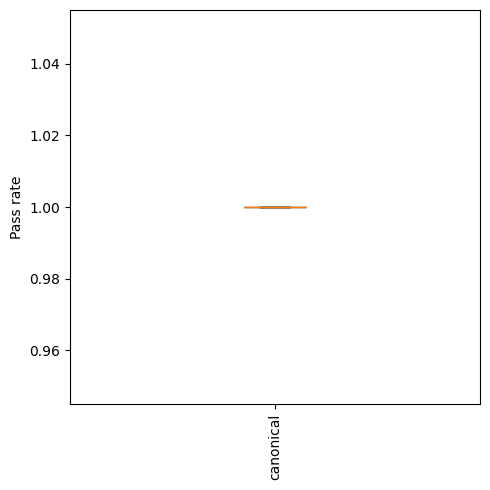

In [6]:
# Assuming pivot_df has 'task_id' as a non-numerical column and the rest are numerical and need to be plotted
numerical_data = pivot_df.drop(columns=['task_id'])

# Calculate the mean of each column and sort these means in descending order
mean_values = numerical_data.mean().sort_values(ascending=False)

# Reorder columns in numerical_data based on sorted mean values
ordered_numerical_data = numerical_data[mean_values.index]

# Plotting the boxplot with reordered columns
plt.figure(figsize=(5, 5))
boxplot = plt.boxplot(ordered_numerical_data, patch_artist=True, labels=ordered_numerical_data.columns)

# Adding colors
# colors = ['lightblue'] * len(ordered_numerical_data.columns)
#for patch, color in zip(boxplot['boxes'], colors):
#    patch.set_facecolor(color)

# plt.title('Pass rate for generated BIA Python code')
plt.xticks(rotation=90)  # Rotate labels to avoid overlap
plt.ylabel('Pass rate')  # Optionally adjust the label to suit the data context
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()